# Model Training

## Importing

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from model.models import Model_1
from testing import test_model, pred_patches
from dataloader import DataLoader
from model.losses import FocalLoss
from model.callbacks import UpdateAccuracy
from ops import reconstruct_image
import os
import json
import shutil
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import average_precision_score

## Parameters

In [2]:
# load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

# load the params-patches.json options
with open(os.path.join('v1', 'params-training.json')) as param_file:
    params_training = json.load(param_file)
    
#load the params-model.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)

#load the shapes.json options
with open('shapes.json') as param_file:
    shapes_json = json.load(param_file)

In [3]:
patches_path = params_patches['patches_path']

train_path = os.path.join(patches_path, params_patches['train_sub'])
val_path = os.path.join(patches_path, params_patches['val_sub'])
test_path = os.path.join(patches_path, params_patches['test_sub'])

## Setting Dataloaders

In [4]:
dl_train = DataLoader(
    batch_size = params_training['batch_size'],
    data_path=os.path.join(train_path, params_patches['data_sub']),
    label_path=os.path.join(train_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    shuffle=True, 
    limit=params_training['patch_limit'])

dl_val = DataLoader(
    batch_size=params_training['batch_size'],
    data_path=os.path.join(val_path, params_patches['data_sub']),
    label_path=os.path.join(val_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3,
    limit=params_training['patch_limit'])

dl_test = DataLoader(
    #batch_size=params_training['batch_size'],
    batch_size=3,
    data_path=os.path.join(test_path, params_patches['data_sub']),
    label_path=os.path.join(test_path, params_patches['label_sub']),
    patch_size=128,
    opt_bands=8,
    sar_bands=4,
    num_classes=3)

## Model definition

In [5]:
model = Model_1(name='modelo_1')

metrics = {
}

weights = [0.2, 0.8, 0.0]

learning_rate = InverseTimeDecay(
    initial_learning_rate=0.1, 
    decay_steps=params_training['learning_reduction']*len(dl_train),
    decay_rate = 0.1,
    staircase=True
    )

optimizers = {
    'opt': tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9),
    'sar': tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9),
    'fusion': tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9),
}

class_indexes = [0, 1]

model.compile(
    optimizers = optimizers,
    loss_fn = FocalLoss,
    metrics_dict = metrics,
    class_weights = weights,
    class_indexes = class_indexes,
    run_eagerly=params_training['run_eagerly']
)

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_combined_f1score',
        patience = params_training['patience'],
        mode = 'max',
        restore_best_weights=True),
    UpdateAccuracy()
]


history = model.fit(
    x=dl_train,
    validation_data=dl_val,
    epochs=params_training['epochs_train'],
    callbacks=callbacks,
    verbose = 2
    )

Epoch 1/50
34/34 - 12s - opt_loss: 0.1039 - sar_loss: 0.1152 - fusion_loss: 0.1500 - loss: 0.3691 - opt_accuracy: 0.5966 - sar_accuracy: 0.6118 - fusion_accuracy: 0.5730 - combined_accuracy: 0.6108 - opt_f1score: 0.3724 - sar_f1score: 0.3218 - fusion_f1score: 0.3473 - combined_f1score: 0.3629 - val_opt_loss: 0.0199 - val_sar_loss: 0.0145 - val_fusion_loss: 0.0132 - val_loss: 0.0476 - val_opt_accuracy: 0.6667 - val_sar_accuracy: 0.6971 - val_fusion_accuracy: 0.7270 - val_combined_accuracy: 0.6761 - val_opt_f1score: 0.5869 - val_sar_f1score: 0.3666 - val_fusion_f1score: 0.3976 - val_combined_f1score: 0.4225
Epoch 2/50
34/34 - 11s - opt_loss: 0.0873 - sar_loss: 0.0938 - fusion_loss: 0.1129 - loss: 0.2940 - opt_accuracy: 0.6043 - sar_accuracy: 0.5677 - fusion_accuracy: 0.5647 - combined_accuracy: 0.5845 - opt_f1score: 0.4178 - sar_f1score: 0.3112 - fusion_f1score: 0.3806 - combined_f1score: 0.3693 - val_opt_loss: 0.0138 - val_sar_loss: 0.0163 - val_fusion_loss: 0.0145 - val_loss: 0.0446 - 

## Show training history

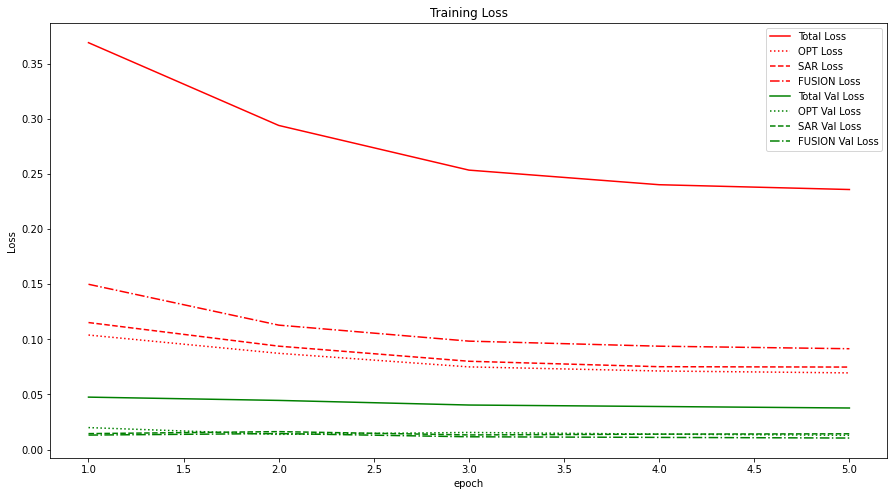

In [7]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['loss'], 'r-',label='Total Loss')
plt.plot(x, history.history['opt_loss'], 'r:',label='OPT Loss')
plt.plot(x, history.history['sar_loss'], 'r--',label='SAR Loss')
plt.plot(x, history.history['fusion_loss'], 'r-.',label='FUSION Loss')

plt.plot(x, history.history['val_loss'], 'g-',label='Total Val Loss')
plt.plot(x, history.history['val_opt_loss'], 'g:',label='OPT Val Loss')
plt.plot(x, history.history['val_sar_loss'], 'g--',label='SAR Val Loss')
plt.plot(x, history.history['val_fusion_loss'], 'g-.',label='FUSION Val Loss')

plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.savefig('graphics/Loss.png')
plt.show()

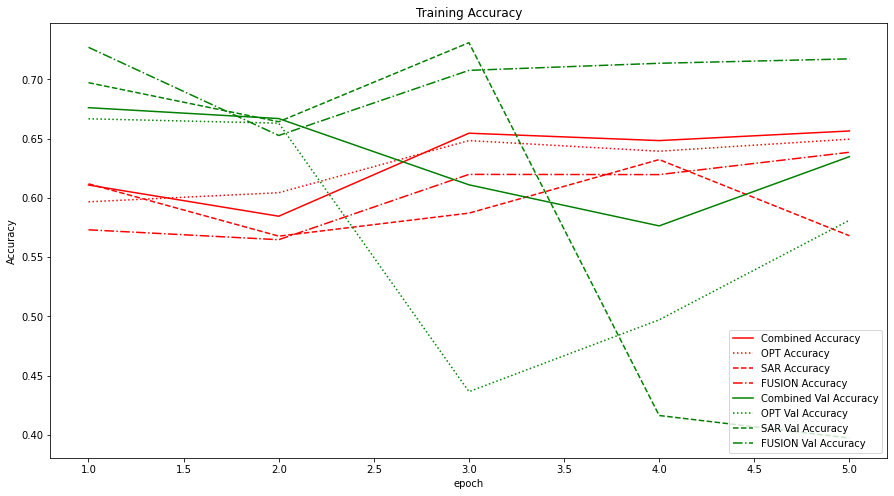

In [8]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['combined_accuracy'], 'r-',label='Combined Accuracy')
plt.plot(x, history.history['opt_accuracy'], 'r:',label='OPT Accuracy')
plt.plot(x, history.history['sar_accuracy'], 'r--',label='SAR Accuracy')
plt.plot(x, history.history['fusion_accuracy'], 'r-.',label='FUSION Accuracy')

plt.plot(x, history.history['val_combined_accuracy'], 'g-',label='Combined Val Accuracy')
plt.plot(x, history.history['val_opt_accuracy'], 'g:',label='OPT Val Accuracy')
plt.plot(x, history.history['val_sar_accuracy'], 'g--',label='SAR Val Accuracy')
plt.plot(x, history.history['val_fusion_accuracy'], 'g-.',label='FUSION Val Accuracy')

plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('graphics/Accuracy.png')
plt.show()

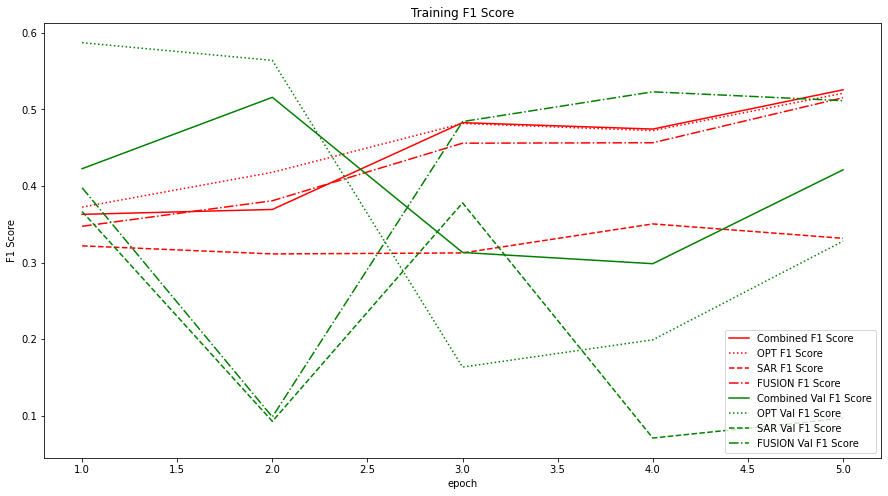

In [9]:
plt.figure(figsize=(15, 8))
x = np.arange(len(history.history['loss']))+1
plt.plot(x, history.history['combined_f1score'], 'r-',label='Combined F1 Score')
plt.plot(x, history.history['opt_f1score'], 'r:',label='OPT F1 Score')
plt.plot(x, history.history['sar_f1score'], 'r--',label='SAR F1 Score')
plt.plot(x, history.history['fusion_f1score'], 'r-.',label='FUSION F1 Score')

plt.plot(x, history.history['val_combined_f1score'], 'g-',label='Combined Val F1 Score')
plt.plot(x, history.history['val_opt_f1score'], 'g:',label='OPT Val F1 Score')
plt.plot(x, history.history['val_sar_f1score'], 'g--',label='SAR Val F1 Score')
plt.plot(x, history.history['val_fusion_f1score'], 'g-.',label='FUSION Val F1 Score')

plt.title('Training F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.savefig('graphics/F1score.png')
plt.show()

## Evaluation 

In [10]:
opt_avg_prec_list = []
sar_avg_prec_list = []
fusion_avg_prec_list = []
combined_avg_prec_list = []


pred_path = params_patches['pred_path']
shutil.rmtree(pred_path, ignore_errors=True)
os.makedirs(pred_path)


for tile_n in params_patches['test_tiles']:
    dl_test.set_tile(int(tile_n))

    shape_tile = shapes_json[str(tile_n)]

    y_true = np.load(os.path.join(params_patches['tiles_path'], params_patches['label_sub'], f'label_{tile_n:02d}.npy'))
    y_true = to_categorical(y_true, 3)[:, :, 1]

    predictions_opt = []
    predictions_sar = []
    predictions_fusion = []
    predictions_combined = []

    for batch in tqdm(range(len(dl_test))):
        pred = model.predict_on_batch(dl_test[batch][0])
        predictions_opt.append(pred[0])
        predictions_sar.append(pred[1])
        predictions_fusion.append(pred[2])
        predictions_combined.append(pred[3])  

    predictions_opt = np.concatenate(predictions_opt, axis=0)  
    predictions_sar = np.concatenate(predictions_sar, axis=0)  
    predictions_fusion = np.concatenate(predictions_fusion, axis=0)  
    predictions_combined = np.concatenate(predictions_combined, axis=0)  

    predictions_opt_rec = reconstruct_image(predictions_opt, params_patches['patch_stride'], shape_tile)
    predictions_sar_rec = reconstruct_image(predictions_sar, params_patches['patch_stride'], shape_tile)
    predictions_fusion_rec = reconstruct_image(predictions_fusion, params_patches['patch_stride'], shape_tile)
    predictions_combined_rec = reconstruct_image(predictions_combined, params_patches['patch_stride'], shape_tile)

    np.save(os.path.join(params_patches['pred_path'], f'pred_opt_{tile_n:02d}.npy'), predictions_opt_rec)
    np.save(os.path.join(params_patches['pred_path'], f'pred_sar_{tile_n:02d}.npy'), predictions_sar_rec)
    np.save(os.path.join(params_patches['pred_path'], f'pred_fusion_{tile_n:02d}.npy'), predictions_fusion_rec)
    np.save(os.path.join(params_patches['pred_path'], f'pred_combined_{tile_n:02d}.npy'), predictions_combined_rec)

    opt_avg_prec = average_precision_score(y_true.flatten(), predictions_opt_rec[:,:,1].flatten())
    sar_avg_prec = average_precision_score(y_true.flatten(), predictions_sar_rec[:,:,1].flatten())
    fusion_avg_prec = average_precision_score(y_true.flatten(), predictions_fusion_rec[:,:,1].flatten())
    combined_avg_prec = average_precision_score(y_true.flatten(), predictions_combined_rec[:,:,1].flatten())

    opt_avg_prec_list.append(opt_avg_prec)
    sar_avg_prec_list.append(sar_avg_prec)
    fusion_avg_prec_list.append(fusion_avg_prec)
    combined_avg_prec_list.append(combined_avg_prec)

    print(f'Precision Average of OPT prediction of tile {tile_n} is {opt_avg_prec:.4f}')
    print(f'Precision Average of SAR prediction of tile {tile_n} is {sar_avg_prec:.4f}')
    print(f'Precision Average of FUSION prediction of tile {tile_n} is {fusion_avg_prec:.4f}')
    print(f'Precision Average of COMBINED prediction of tile {tile_n} is {combined_avg_prec:.4f}')




100%|██████████| 2976/2976 [03:41<00:00, 13.41it/s]


Precision Average of OPT prediction of tile 2 is 0.0717
Precision Average of SAR prediction of tile 2 is 0.0246
Precision Average of FUSION prediction of tile 2 is 0.0666
Precision Average of COMBINED prediction of tile 2 is 0.0682


 30%|██▉       | 887/2976 [02:33<05:57,  5.84it/s]